# 炉温的PID控制

**Eärendil**

**2017/12/4**

## 原理

### PID控制原理

比例作用是控制的基础；积分作用消除误差；微分控制减小超调量，加快速度。

复频域下的传递函数：$$G_c(s)=K_p+\left(1+\frac{1}{T_i s}+T_d s\right)$$
变换到时域：$$u(t)=K_p\left(e(t)+\frac 1 {T_i}\int_0^t e(t){\rm d}t+T_d\frac{{\rm d}e(t)}{{\rm d}t}\right)$$
变换为增量式：$$\Delta u_k=K_p(1+\frac T{Ti}+\frac{T_d}T)e_k-K_p(1+\frac{2T_d}T)e_{k-1}+K_p\frac{T_d}Te_{k-2}$$

### 参数整定

即调节$K_P,T_I,T_D$。可用期望信号与实际信号的残差平方和判别参数的好坏。在调节之前先将各参数初始化为$K_p=0,T_i=\infty,T_d=0$

- 试凑法：先调节$K_P$（由小到大）至基本符合要求，若静差过大则调节$T_I$（由大至小调节，可以同时减小$K_P$)，超调量过大、调节时间过长则调节$T_D$（由大至小调节，可以同时调节$K_P$和$T_I$）
- 临界比例度法：先将$K_p$设为较大值，从大到小调节，至出现等幅振荡，记录此时的比例度$\delta_K$和振荡周期$T_K$；之后按经验公式$K_P=\frac{1.7}{2}\delta_K,T_I=0.5T_K,T_D=0.125T_K$算出各参数；最后在算出的参数值附近进行进一步调节。

## 实验数据处理

In [1]:
%pylab inline
%xmode Plain
%config InlineBackend.figure_format="svg"
import pandas as pd

Populating the interactive namespace from numpy and matplotlib
Exception reporting mode: Plain


In [2]:
# 控制效果判别
def report(st,co,time):
    ISE=sum((st-co)**2)/time[-1]
    ess=mean(abs(co[-10:]-st[-10:]))
    ts=time[abs(st-co)>0.05*(st[-1]-co[0])].max()
    sigma=(co-st).max()
    out="残差平方和为"+str(ISE)+"\n稳态误差为"+str(ess)+"℃\n超调量为"+str(sigma)+"℃\n调整时间为"+str(ts)+"s"
    return out

残差平方和为2821.78163556
稳态误差为0.037℃
超调量为0.95℃
调整时间为17.5s


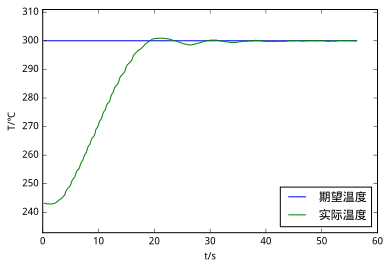

In [3]:
data=array(pd.read_csv('F:/学习/材料数字化技术/PID炉温控制/wanghao_PID.csv'))
time,voltage,expected,actual=data[:,0],data[:,1],data[:,2],data[:,3]
plot(time,expected,label='期望温度')
plot(time,actual,label='实际温度')
legend(loc='lower right')
ylim(actual.min()-10,actual.max()+10)
xlabel('t/s')
ylabel('T/℃')
print(report(expected,actual,time))

## 程序模拟

可以采用程序模拟加热炉系统，这样可以在实物测试前预先确定PID控制参数的大致范围，节约试验时间。但是我在此之前并没有加热炉系统的详细信息，因此在这里实际上是根据试验结果建立了加热炉模型。

### PID控制系统建模

考虑到加热电压u的实际取值范围，除了基本PID控制外，加入约束$0 \leq u \leq 10$

这种约束可以近似的用函数$X_{out}=X_{max}\tanh \frac{X_{in}}{X_{max}}$表示。在电路中，这种约束则很容易用运算放大器一类的原件实现。

约束方法不是唯一的，应当根据实际电路选取更合适的模型。

In [4]:
# 主控制函数
def PIDcontrol(err,i,u_0,Kp,Ti,Td):
    if i==0:
        du=Kp*(1+T/Ti+Td/T)*err[i]
    elif i==1:
        du=Kp*((1+T/Ti+Td/T)*err[i]-(1+2*Td/T)*err[i-1])
    else:
        du=Kp*((1+T/Ti+Td/T)*err[i]-(1+2*Td/T)*err[i-1]+Td/T*err[i-2])
    u=u_0+du
    if u<0:
        u=0
    elif u>10:
        u=10
    return u

### 加热炉建模

In [5]:
# 基本参数

T=0.2
samp_times=300
time=arange(0,samp_times)*T
start=243+273
env=15+273
start_time=0
end=300+273

不能直接套用之前实验得到的加热速度$k_T=2.93U-4.95$，因为

- 升温速度还与当前温度$T$有关；
- 可以假设加热器温度对电压及时响应，而体系（温度传感器位置）绝不可能；
- 在$2V\sim 3V$范围内的线性关系不能无限推广。例如按此关系，$U=0$时，$k_T=-4.95$，明显快于实际情况。

实际上很难模拟，在这里取一个简单模型。根据实际PID实验的结果，取$T=270℃$附近升温速率$k_{Tup}$与加热电压$U$的关系为$k_{Tup}=0.5U$，存在延时效应（延迟0.4s），散热速率$k_{Tdown}$与当前温度$T$和环境温度$T_{env}$的关系为$k_{Tdown}=2.91\ln(\frac{T}{T_{env}})$，即$T_i=T_{i-1}+(k_{Tup,i-0.2s/T}-k_{Tdown,i-1}){\rm d}t$

In [6]:
# 加热炉模型
def stove(u,i,Temp):
    times_delay=3
    if i<times_delay:
        up=0
    else:
        up=0.6*u[i-times_delay]
    down=2.91*log(Temp/env)
    return Temp+(up-down)*T

### 模拟参数整定与模拟结果

结合试凑法与经验公式，可以得到一组合适的参数：

残差平方和为1559.02217635
稳态误差为0.013474605183℃
超调量为3.45174439754℃
调整时间为17.0s
最大控制电压 10.0 V


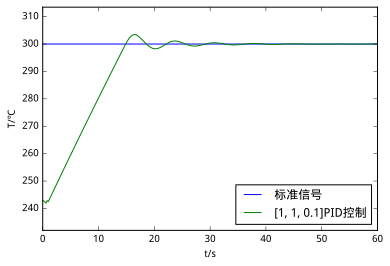

In [7]:
# 信号初始化
# 设定变量
Kp,Ti,Td=1,1,0.1

standard=r_[ones(start_time)*start,ones(samp_times-start_time)*end]
controled=r_[start,empty(samp_times-1)]
err=empty(samp_times)
u=r_[0,empty(samp_times-1)]
err[0]=standard[0]-controled[0]

# 控制循环
for i in arange(1,samp_times):
    u[i]=PIDcontrol(err,i-1,u[i-1],Kp,Ti,Td)
    controled[i]=stove(u,i,controled[i-1])
    err[i]=standard[i]-controled[i]

plot(time,standard-273,label='标准信号')
plot(time,controled-273,label=str([Kp,Ti,Td])+"PID控制")
legend(loc='lower right')
ylim(controled.min()-283,controled.max()-263)
xlabel('t/s')
ylabel('T/℃')
print(report(standard-273,controled-273,time))
print("最大控制电压",u.max(),"V")